<a href="https://colab.research.google.com/github/williamfaraday123/SC3000-AI/blob/main/SC3000Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Dependencies

In [1]:
!pip install torch
!pip install gym==0.25 numpy==1.24

## Importing dependencies and defining helper functions

In [2]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt


#to display video
from google.colab import output
output.enable_custom_widget_manager()
from gym.wrappers import RecordVideo
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video width="400" controls>
                            <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                            </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## Task 1: Development of an RL Agent: DQN Model and DQN Agent

In [3]:
#DQN model
class DQN(nn.Module):
  def __init__(self, state_size, action_size):
    super().__init__()
    self.fc1 = nn.Linear(state_size, 24)
    self.fc2 = nn.Linear(24, 24)
    self.fc3 = nn.Linear(24, action_size)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return self.fc3(x)

In [4]:
class DQNAgent():
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.gamma = 0.95  # discount factor
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

    def remember(self, state, action, reward, next_state, terminated):
        self.memory.append((state, action, reward, next_state, terminated))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state)
        act_values = self.model(state)
        return torch.argmax(act_values).item()

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)

        # Convert experiences to properly shaped tensors
        states = torch.FloatTensor(np.vstack([e[0] for e in minibatch]))
        actions = torch.LongTensor(np.vstack([e[1] for e in minibatch]))
        rewards = torch.FloatTensor(np.vstack([e[2] for e in minibatch]))
        next_states = torch.FloatTensor(np.vstack([e[3] for e in minibatch]))
        dones = torch.FloatTensor(np.vstack([e[4] for e in minibatch]))

        # Get current Q values for all actions
        current_q = self.model(states)

        # Select Q values for taken actions
        current_q = current_q.gather(1, actions)

        # Get max Q values for next states
        next_q = self.model(next_states).detach().max(1)[0].unsqueeze(1)

        # Compute target Q values
        target_q = rewards + (1 - dones) * self.gamma * next_q

        # Compute loss
        loss = nn.MSELoss()(current_q, target_q)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

## Loading CartPole environment

In [5]:
env = gym.make("CartPole-v1")

/usr/local/lib/python3.11/dist-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [6]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [7]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)



We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [8]:
observation = env.reset()
state_size = env.observation_space.shape[0]
print("Initial observations:", observation)
state = np.reshape(observation, [1, state_size])
print("State:", state)

Initial observations: [0.02356001 0.02439054 0.02415068 0.03962673]
State: [[0.02356001 0.02439054 0.02415068 0.03962673]]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [9]:
observation, reward, done, info = env.step(0)
print("Observations", observation)
print("Chosen action: 0")
print("Reward for this step:", reward)
print("Is this round done?", done)

Observations [ 0.02404782 -0.17106926  0.02494321  0.33983052]
Chosen action: 0
Reward for this step: 1.0
Is this round done? False


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


## Task 2: Train the Agent (100 episodes)

In [10]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
batch_size = 32
episodes = 100
rewards = []

for e in range(episodes):
  state = env.reset()
  state = np.reshape(state, [1, state_size])
  total_reward = 0
  terminated = False
  truncated = False
  step_count = 0

  while (not terminated and not truncated):
    action = agent.act(state) #agent decides an action
    next_state, reward, terminated, _ = env.step(action) #environment responds to action
    next_state = np.reshape(next_state, [1, state_size])

    # check termination conditions
    pole_angle = np.rad2deg(next_state[0][2])
    cart_position = next_state[0][0]
    if abs(pole_angle) > 12 or abs(cart_position) > 2.4:
      terminated = True

    agent.remember(state, action, reward, next_state, terminated) #store the experience for later training
    state = next_state #update state
    total_reward += reward #track total reward

    # check if truncated
    step_count += 1
    truncated = (step_count > 500)

    if terminated or truncated:
      print(f"Episode: {e+1}/{episodes}, Score: {total_reward}, Epsilon: {agent.epsilon:.2f}")
      rewards.append(total_reward)
      break

    if len(agent.memory) > batch_size:
      agent.replay(batch_size) #train the agent (if agent has enough experiences in memory)


Episode: 1/100, Score: 15.0, Epsilon: 1.00
Episode: 2/100, Score: 21.0, Epsilon: 0.99
Episode: 3/100, Score: 14.0, Epsilon: 0.92
Episode: 4/100, Score: 14.0, Epsilon: 0.86
Episode: 5/100, Score: 12.0, Epsilon: 0.82
Episode: 6/100, Score: 19.0, Epsilon: 0.75
Episode: 7/100, Score: 22.0, Epsilon: 0.67
Episode: 8/100, Score: 16.0, Epsilon: 0.62
Episode: 9/100, Score: 11.0, Epsilon: 0.59
Episode: 10/100, Score: 13.0, Epsilon: 0.56
Episode: 11/100, Score: 23.0, Epsilon: 0.50
Episode: 12/100, Score: 10.0, Epsilon: 0.48
Episode: 13/100, Score: 12.0, Epsilon: 0.45
Episode: 14/100, Score: 11.0, Epsilon: 0.43
Episode: 15/100, Score: 9.0, Epsilon: 0.41
Episode: 16/100, Score: 14.0, Epsilon: 0.39
Episode: 17/100, Score: 12.0, Epsilon: 0.37
Episode: 18/100, Score: 10.0, Epsilon: 0.35
Episode: 19/100, Score: 11.0, Epsilon: 0.33
Episode: 20/100, Score: 17.0, Epsilon: 0.31
Episode: 21/100, Score: 10.0, Epsilon: 0.29
Episode: 22/100, Score: 11.0, Epsilon: 0.28
Episode: 23/100, Score: 9.0, Epsilon: 0.27

## Task 2: Plot the Results

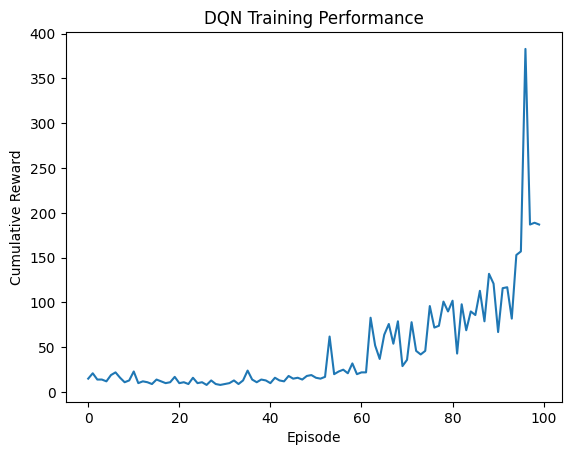

In [11]:
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('DQN Training Performance')
plt.show()

## Task 3: Test the Agent by rendering 1 episode

In [12]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
state = env.reset()
state = np.reshape(state, [1, state_size])
total_reward = 0
done = False

while not done:
  env.render()
  action = agent.act(state)
  next_state, reward, done, _ = env.step(action)
  next_state = np.reshape(next_state, [1, state_size])
  state = next_state
  total_reward += reward

print(f"Total Reward: {total_reward}")
env.close()
show_video()

/usr/local/lib/python3.11/dist-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:51: DeprecationWarning: WARN: The argument mode in render method is dep

Total Reward: 202.0
